In [97]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf, keras, and sklearn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
# OpenTSNE imports

import gzip
import pickle

import numpy as np
import openTSNE

In [13]:
embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="euclidean",
    n_jobs=8,
    random_state=3,
).fit(x)

In [52]:
greeks = pd.read_csv('../data/greeks.csv')
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

greeks.columns = map(str.lower, greeks.columns)
test.columns = map(str.lower, test.columns)
train.columns = map(str.lower, train.columns)

In [53]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

features_variable.columns = train.drop(['class', 'id'], axis=1).columns

In [129]:
def feature_reduction(method, num_features, data_split, kernel = 'rbf'):
    
    if method == 'pca' or method == 'kpca':
        # Split into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(X_train)

        X_train_std = sc.transform(X_train)
        X_test_std = sc.transform(X_test)

        # PCA/kPCA
        if method == 'pca':
            pca = PCA(n_components = num_features)
            pca.fit(X_train_std)
            variance_ratio = np.cumsum(pca.explained_variance_ratio_) * 100
            X_train_pca = pd.DataFrame(pca.transform(X_train_std))
            X_test_pca = pd.DataFrame(pca.transform(X_test_std))
        elif method == 'kpca':
            pca = KernelPCA(n_components = num_features, kernel = kernel)
            pca.fit(X_train_std)

            X_train_pca = pd.DataFrame(pca.transform(X_train_std))
            X_test_pca = pd.DataFrame(pca.transform(X_test_std))

            # kPCA does not have a feature for explained_variance_ratio_
            # because of the kernel transformation. The once the transformation
            # occurs, the data lives in a different feature space.
            # https://stackoverflow.com/a/40687862

            variance_ratio = None

        return X_train_pca, X_test_pca, y_train, y_test, variance_ratio

    elif method == 'tsne':
        # Standardize values via StandardScaler
        sc = StandardScaler().fit(features_variable)
        features_variable_std = sc.transform(features_variable)

        tsne = TSNE(n_components=num_features, random_state=0, perplexity=10)

        # Calculate the 12 features via tSNE model
        features_variable_tsne = pd.DataFrame(tsne.fit_transform(features_variable_std))

        # kl_divergence (lower is better)
        divergence = tsne.kl_divergence_

        #Split into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(features_variable_tsne, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
        return X_train, X_test, y_train, y_test, divergence

In [130]:
X_train, X_test, Y_train, Y_test, statistic = feature_reduction(method='tsne', num_features=2, data_split=0.2)

In [55]:
embedding_standard = openTSNE.TSNE(
    perplexity=30,
    initialization="random",
    metric="euclidean",
    n_jobs=8,
    random_state=3,
).fit(features_variable)

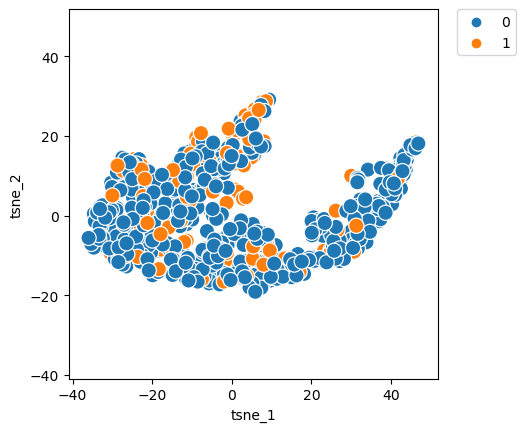

In [144]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, perplexity = 25)
tsne_result = tsne.fit_transform(features_variable)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': target_variable})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [1]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(35,35))

data = []
for i in (5, 10, 15, 20, 25, 30, 35, 40, 45, 50):
    for idx, ax in enumerate(axes.flatten()):
        n_components = 2
        tsne = TSNE(n_components, perplexity = i, learning_rate = 10, n_iter = (idx+1)*250)
        tsne_result = tsne.fit_transform(features_variable)
        tsne_result.shape
        # (1000, 2)
        # Two dimensions for each of our images
        
        # Plot the result of our TSNE with the label color coded
        # A lot of the stuff here is about making the plot look pretty and not TSNE
        tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0],
                                        'tsne_2': tsne_result[:,1],
                                        'label': target_variable})
        data.append(tsne_result_df)

NameError: name 'plt' is not defined

In [175]:
display(np.sum(features_variable.count()))
display(np.count_nonzero(features_variable))

display(np.count_nonzero(features_variable)/np.sum(features_variable.count())*100)

35169

34552

98.24561403508771

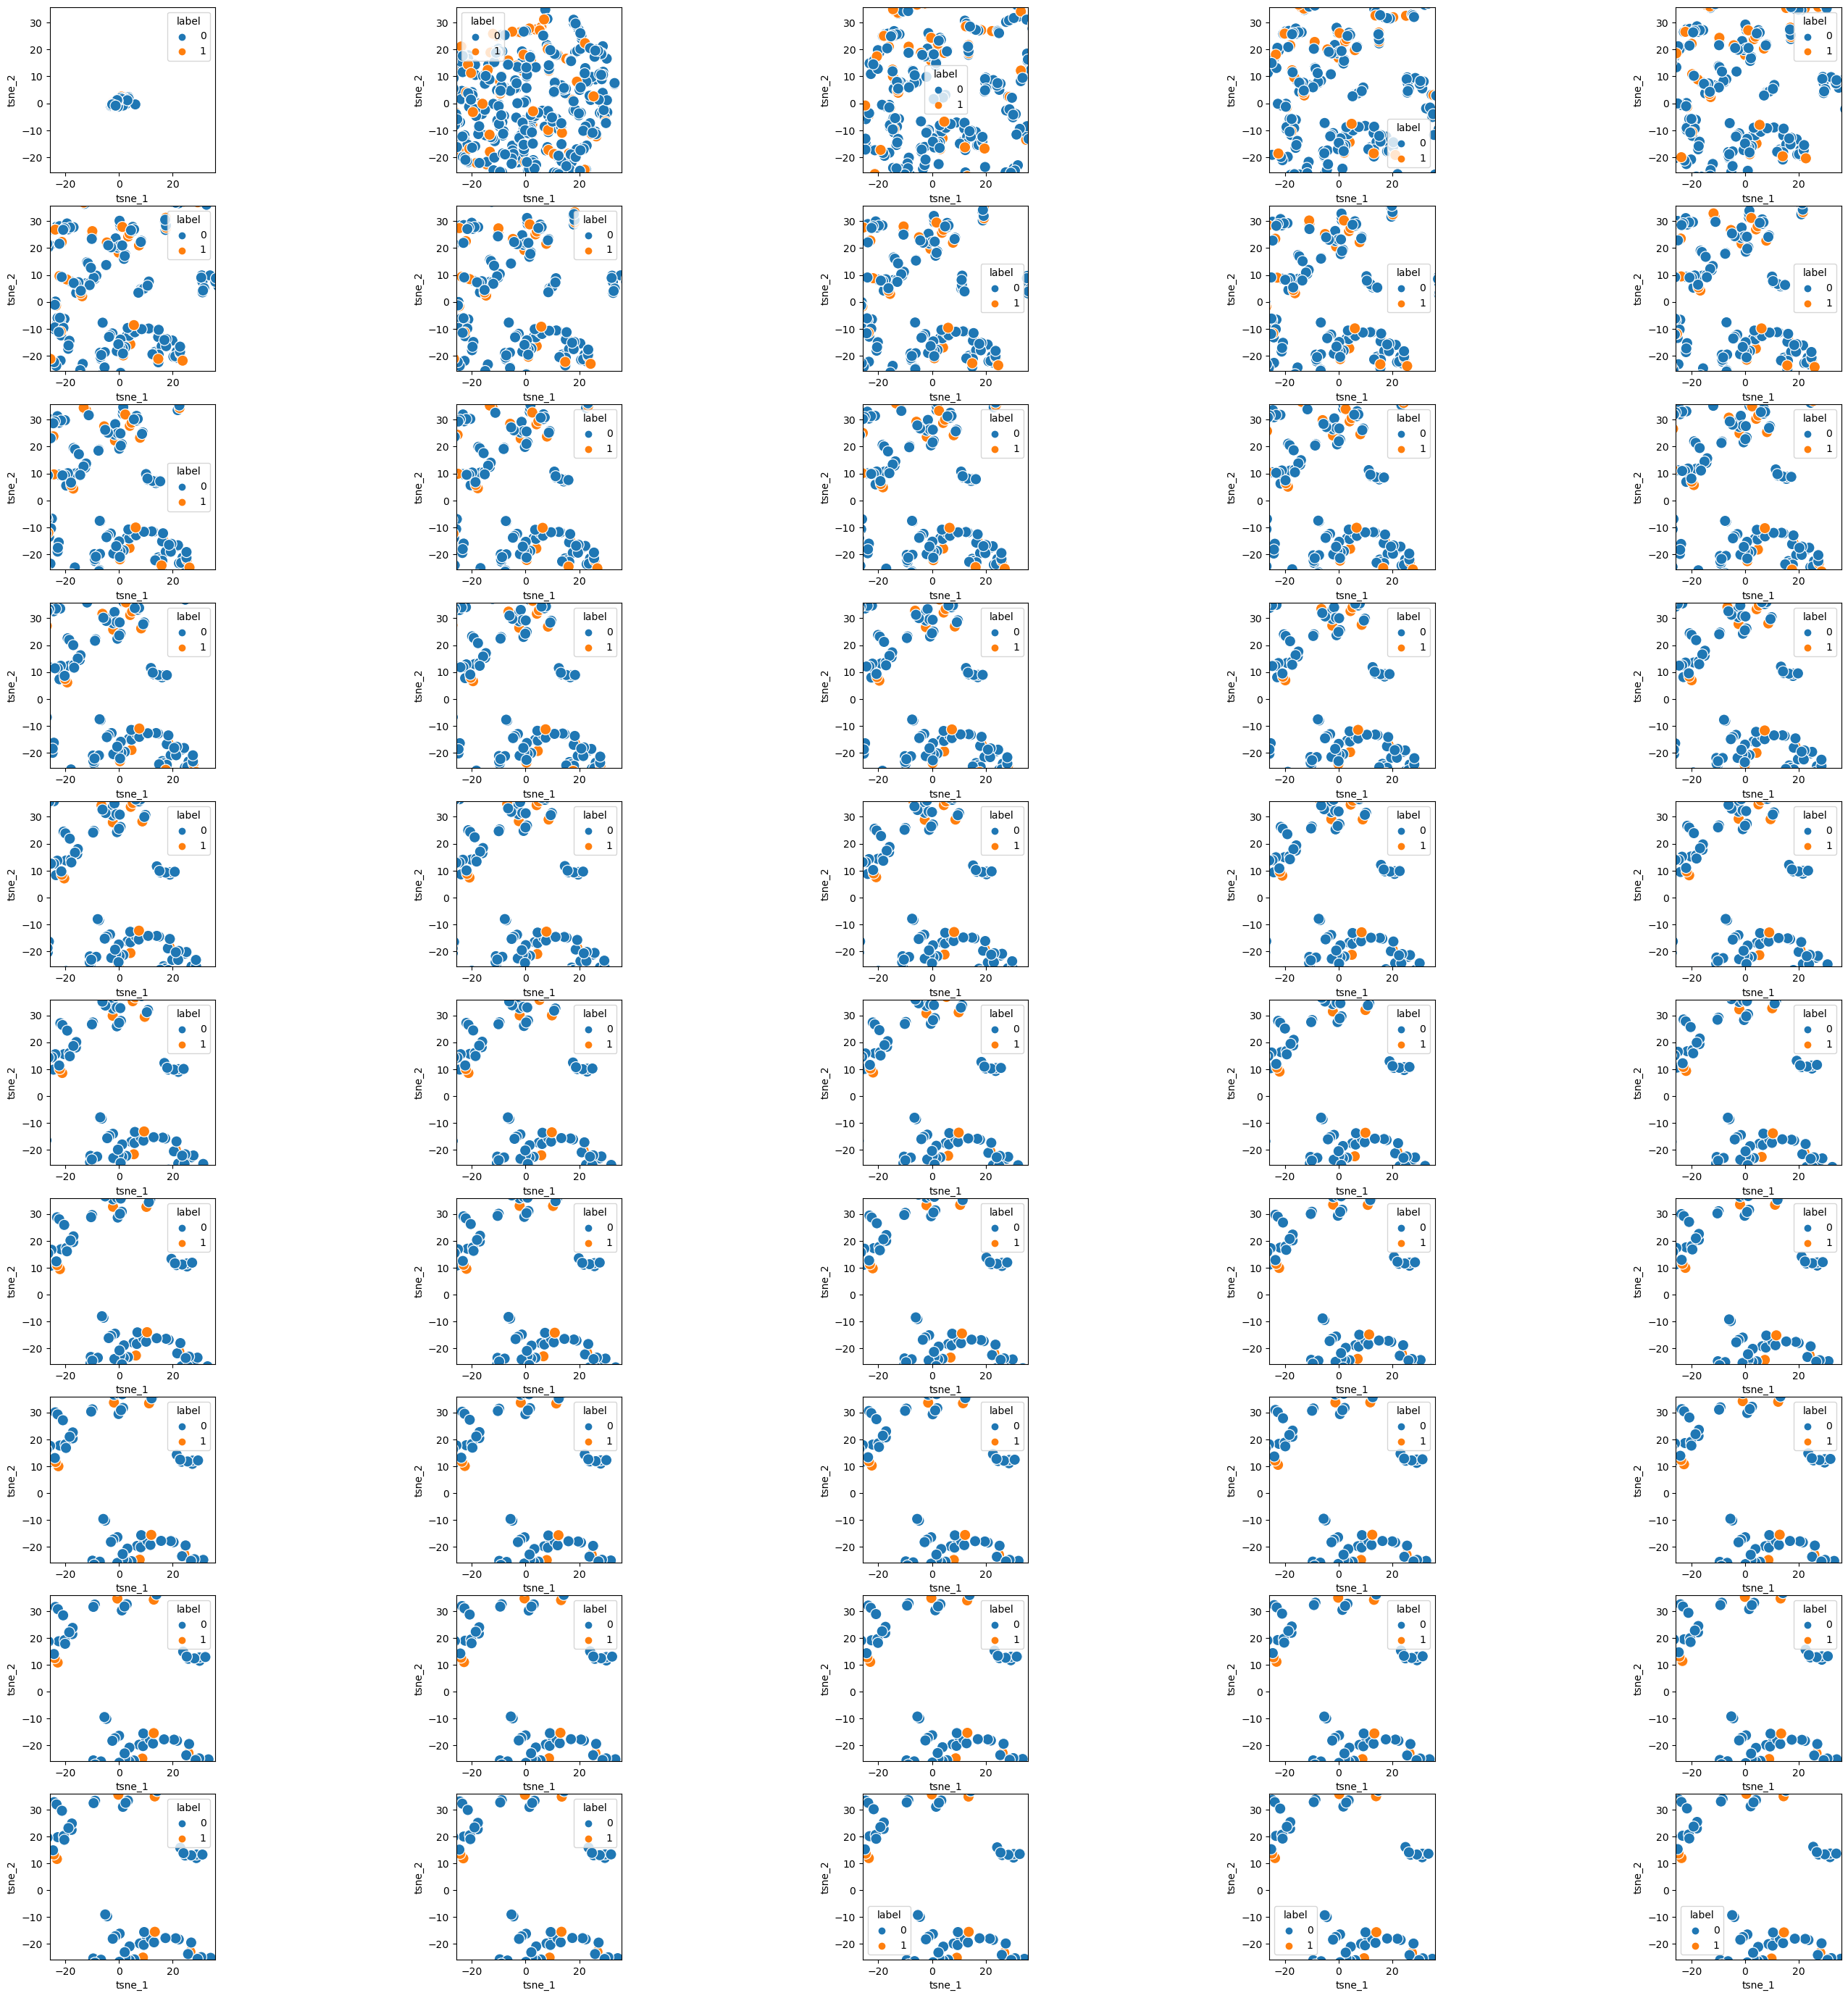

In [180]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(35,35))
for idx, ax in enumerate(axes.flatten()):
        sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=data[idx], ax=ax,s=120)
        lim = (tsne_result.min()-5, tsne_result.max()+5)
        ax.set_xlim(lim)
        ax.set_ylim(lim)
        ax.set_aspect('equal')
        # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.savefig('tsne.png', dpi=600)